In [1]:
import networkx as nx
import numpy as np
import sys
from heapdict import *
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, average_precision_score, roc_auc_score

from utils import *

# Hierarchical metrics

## Euclidean divergence

In [2]:
def euclidean(graph, dendrogram):
    graph_copy = graph.copy()
    n_nodes = np.shape(dendrogram)[0] + 1

    w = {u: 0 for u in range(n_nodes)}
    wtot = 0
    for (u, v) in graph_copy.edges():
        weight = graph_copy[u][v]['weight']
        w[u] += weight
        w[v] += weight
        wtot += 2 * weight
    
    u = n_nodes
    similarity = 0
    sum_qsig = 0
    pi = {t: w[t]/float(wtot) for t in range(n_nodes)}
    for t in range(n_nodes - 1):
        a = int(dendrogram[t][0])
        b = int(dendrogram[t][1])
        d = dendrogram[t][2]

        w[u] = w.pop(a) + w.pop(b)
        pi[u] = w[u] / float(wtot)

        pi_a = pi[a]
        pi_b = pi[b]
        if graph_copy.has_edge(a, b):
            p_ab = 2 * graph_copy[a][b]['weight'] / float(wtot)
            similarity += (p_ab - (pi_a * pi_b))**2

        # Update graph
        graph_copy.add_node(u)
        neighbors_a = list(graph_copy.neighbors(a))
        neighbors_b = list(graph_copy.neighbors(b))
        for v in neighbors_a:
            graph_copy.add_edge(u, v, weight=graph_copy[a][v]['weight'])
        for v in neighbors_b:
            if graph_copy.has_edge(u, v):
                graph_copy[u][v]['weight'] += graph_copy[b][v]['weight']
            else:
                graph_copy.add_edge(u, v, weight=graph_copy[b][v]['weight'])
        graph_copy.remove_node(a)
        graph_copy.remove_node(b)

        u += 1

    return similarity

## Dasgupta divergence

In [3]:
def dasgupta(graph, dendrogram):
    graph_copy = graph.copy()
    n_nodes = np.shape(dendrogram)[0] + 1

    w = {u: 0 for u in range(n_nodes)}
    wtot = 0
    for (u, v) in graph_copy.edges():
        weight = graph_copy[u][v]['weight']
        w[u] += 1
        w[v] += 1
        wtot += 2
    
    u = n_nodes
    similarity = 0
    sum_qsig = 0
    pi = {t: w[t]/float(wtot) for t in range(n_nodes)}
    for t in range(n_nodes - 1):
        a = int(dendrogram[t][0])
        b = int(dendrogram[t][1])
        d = dendrogram[t][2]

        w[u] = w.pop(a) + w.pop(b)
        pi[u] = w[u] / float(wtot)

        pi_a = pi[a]
        pi_b = pi[b]
        if graph_copy.has_edge(a, b):
            p_ab = 2 * graph_copy[a][b]['weight'] / float(wtot)
            similarity += p_ab * (pi_a + pi_b)

        # Update graph
        graph_copy.add_node(u)
        neighbors_a = list(graph_copy.neighbors(a))
        neighbors_b = list(graph_copy.neighbors(b))
        for v in neighbors_a:
            graph_copy.add_edge(u, v, weight=graph_copy[a][v]['weight'])
        for v in neighbors_b:
            if graph_copy.has_edge(u, v):
                graph_copy[u][v]['weight'] += graph_copy[b][v]['weight']
            else:
                graph_copy.add_edge(u, v, weight=graph_copy[b][v]['weight'])
        graph_copy.remove_node(a)
        graph_copy.remove_node(b)

        u += 1

    return similarity

## Tree Sampling Divergence 

In [4]:
def tsd(graph, dendrogram, normalized=True):
    graph_copy = graph.copy()
    n_nodes = np.shape(dendrogram)[0] + 1

    w = {u: 0 for u in range(n_nodes)}
    wtot = 0
    for (u, v) in graph_copy.edges():
        weight = graph_copy[u][v]['weight']
        w[u] += weight
        w[v] += weight
        wtot += 2 * weight
    
    u = n_nodes
    similarity = 0
    sum_qsig = 0
    pi = {t: w[t]/float(wtot) for t in range(n_nodes)}
    p = {t: w[t]/float(wtot) for t in range(n_nodes)}
    for t in range(n_nodes - 1):
        a = int(dendrogram[t][0])
        b = int(dendrogram[t][1])
        d = dendrogram[t][2]

        w[u] = w.pop(a) + w.pop(b)
        pi[u] = w[u] / float(wtot)

        pi_a = pi[a]
        pi_b = pi[b]
        if graph_copy.has_edge(a, b):
            p_ab = 2 * graph_copy[a][b]['weight'] / float(wtot)
            similarity += p_ab * np.log(p_ab / (pi_a * pi_b))
            sum_qsig += p_ab

        # Update graph
        graph_copy.add_node(u)
        neighbors_a = list(graph_copy.neighbors(a))
        neighbors_b = list(graph_copy.neighbors(b))
        for v in neighbors_a:
            graph_copy.add_edge(u, v, weight=graph_copy[a][v]['weight'])
        for v in neighbors_b:
            if graph_copy.has_edge(u, v):
                graph_copy[u][v]['weight'] += graph_copy[b][v]['weight']
            else:
                graph_copy.add_edge(u, v, weight=graph_copy[b][v]['weight'])
        graph_copy.remove_node(a)
        graph_copy.remove_node(b)

        u += 1
    
    similarity -= np.log(sum_qsig)
    
    if normalized:
        norm = 0
        for u, v in graph.edges():
            p_uv = 2 * graph[u][v]['weight'] / float(wtot)
            norm += p_uv * np.log(p_uv / (p[u] * p[v]))
        similarity /= norm
    return similarity

# Reconstruction score

In [5]:
def reconstruction_score(graph, dendrogram):
    graph_copy = graph.copy()
    n_nodes = np.shape(dendrogram)[0] + 1
    reconstructed_score = np.zeros((n_nodes, n_nodes))

    w = {u: 0 for u in range(n_nodes)}
    wtot = 0
    for (u, v) in graph_copy.edges():
        weight = graph_copy[u][v]['weight']
        w[u] += weight
        w[v] += weight
        wtot += 2 * weight
    p = {u: w[u] / float(wtot) for u in range(n_nodes)}
    c = {u: [u] for u in range(n_nodes)}
    
    pi = {t: w[t] / float(wtot) for t in range(n_nodes)}
    
    u = n_nodes
    for t in range(n_nodes - 1):
        a = int(dendrogram[t][0])
        b = int(dendrogram[t][1])
        
        w[u] = w.pop(a) + w.pop(b)
        pi[u] = w[u] / float(wtot)
        pi_a = pi[a]
        pi_b = pi[b]
        if graph_copy.has_edge(a, b):
            p_ab = 2 * graph_copy[a][b]['weight'] / float(wtot)
        else:
            p_ab = 0
        
        for i in c[a]:
            for j in c[b]:
                reconstructed_score[i, j] = p[i] * p[j] * p_ab / (pi_a * pi_b)
                reconstructed_score[j, i] = reconstructed_score[i, j]
        c[u] = c.pop(a) + c.pop(b)

        # Update graph
        graph_copy.add_node(u)
        neighbors_a = list(graph_copy.neighbors(a))
        neighbors_b = list(graph_copy.neighbors(b))
        for v in neighbors_a:
            graph_copy.add_edge(u, v, weight=graph_copy[a][v]['weight'])
        for v in neighbors_b:
            if graph_copy.has_edge(u, v):
                graph_copy[u][v]['weight'] += graph_copy[b][v]['weight']
            else:
                graph_copy.add_edge(u, v, weight=graph_copy[b][v]['weight'])
        graph_copy.remove_node(a)
        graph_copy.remove_node(b)

        u += 1    

    return reconstructed_score / np.sum(reconstructed_score)

# Reconstruction from hierarchies

## HSBM

In [6]:
def shuffle(graph, p):
    graph_copy = graph.copy()
    for u, v in list(graph_copy.edges()):
        if np.random.choice([False, True], p=[p, 1 - p]):
            u_, v_ = np.random.choice(graph_copy.nodes(), 2, replace=False)
            graph_copy.add_edge(u_, v_, weight=graph_copy[u][v]['weight'])
            graph_copy.remove_edge(u, v)
    return graph_copy

In [7]:
def rank_score(graph, score):
    rank_score = []
    for u, v in graph.edges():
        
        rank_u = np.argsort(-score[u,:])
        for r, w in enumerate(rank_u):
            if w in graph.neighbors(u):
                rank_score.append(r)
        
        rank_v = np.argsort(-score[v,:])
        for r, w in enumerate(rank_v):
            if w in graph.neighbors(v):
                rank_score.append(r)
                
    return np.mean(rank_score)

In [8]:
hierarchical_algorithms = {'single': lambda graph: agglomerative_clustering(graph, linkage='single', f= lambda x: 1/float(x), check=True), 
                          'average': lambda graph: agglomerative_clustering(graph, linkage='average', f= lambda x: 1/float(x), check=True),
                          'complete': lambda graph: agglomerative_clustering(graph, linkage='complete', f= lambda x: 1/float(x), check=True),
                          'modular': lambda graph: agglomerative_clustering(graph, linkage='modular', f= lambda x: 1/float(x), check=True)}

## Reconstruction 1: shuffled graph

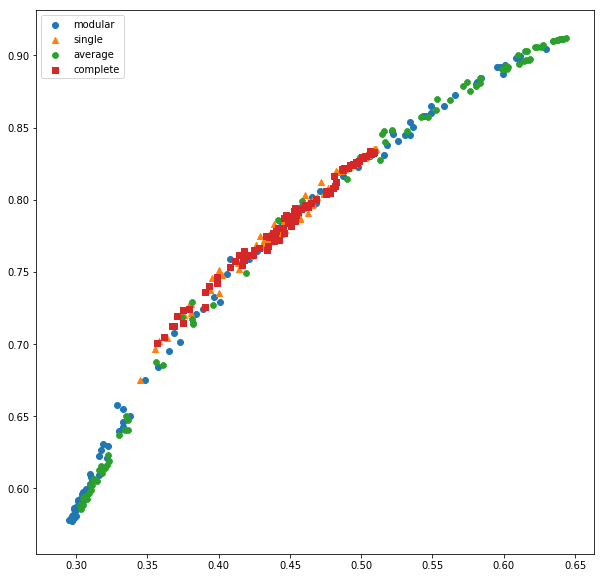

In [26]:
markers = ['o', '^', '8', 's', 'p', '*']
i = 0
plt.figure(figsize=(10, 10))

clean_hsbm = HSBM.balanced(n_levels=3, decay_factor=.3, division_factor=2, core_community_size=20, p_in=.9)
real_graph = clean_hsbm.create_graph(distribution='Binomial')
adj = nx.to_numpy_matrix(real_graph)
n_nodes = real_graph.number_of_nodes()
adj_true = np.reshape(nx.to_numpy_array(real_graph), n_nodes * n_nodes)
adj_true = adj_true.astype(bool).astype(int)
for algo_name, algo in hierarchical_algorithms.items():
    aps, auc, rank = [], [], []
    euc, das, tsds = [], [], []
    for p in np.linspace(0., 1., num=100):
        shuffled_graph = shuffle(real_graph, p)
        d = algo(shuffled_graph)

        reconstructed_adj = reconstruction_score(real_graph, d)
        adj_score = np.reshape(reconstructed_adj, n_nodes * n_nodes)

        aps.append(average_precision_score(adj_true, adj_score))
        auc.append(roc_auc_score(adj_true, adj_score))
        rank.append(rank_score(real_graph, reconstructed_adj))

        tsds.append(tsd(real_graph, d))
        das.append(dasgupta(real_graph, d))
        euc.append(euclidean(real_graph, d))
            
    plt.scatter(tsds, auc, label=algo_name, marker=markers[i])
    plt.legend()
    i += 1
plt.show()

In [ ]:
clean_hsbm = HSBM.balanced(n_levels=3, decay_factor=.3, division_factor=2, core_community_size=20, p_in=.9)
real_graph = clean_hsbm.create_graph(distribution='Binomial')
adj = nx.to_numpy_matrix(real_graph)
n_nodes = real_graph.number_of_nodes()
adj_true = np.reshape(nx.to_numpy_array(real_graph), n_nodes * n_nodes)
adj_true = adj_true.astype(bool).astype(int)
aps, auc, rank = [], [], []
euc, das, tsds = [], [], []
for algo_name, algo in hierarchical_algorithms.items():
    for p in np.linspace(0., 1., num=100):
        shuffled_graph = shuffle(real_graph, p)
        d = algo(shuffled_graph)

        reconstructed_adj = reconstruction_score(real_graph, d)
        adj_score = np.reshape(reconstructed_adj, n_nodes * n_nodes)

        aps.append(average_precision_score(adj_true, adj_score))
        auc.append(roc_auc_score(adj_true, adj_score))
        rank.append(rank_score(real_graph, reconstructed_adj))

        tsds.append(tsd(real_graph, d))
        das.append(dasgupta(real_graph, d))
        euc.append(euclidean(real_graph, d))

In [ ]:
auc = np.array(auc)
aps = np.array(aps)
rank = np.array(rank)
tsds = np.array(tsds)
das = np.array(das)
euc = np.array(euc)

In [ ]:
np.savetxt("auc-1.txt", auc)
np.savetxt("aps-1.txt", aps)
np.savetxt("rank-1.txt", rank)
np.savetxt("tsd-1.txt", tsds)
np.savetxt("das-1.txt", das)
np.savetxt("euc-1.txt", euc)

auc = np.loadtxt("auc-1.txt")
aps = np.loadtxt("aps-1.txt")
rank = np.loadtxt("rank-1.txt")
tsd = np.loadtxt("tsd-1.txt")
das = np.loadtxt("das-1.txt")
euc = np.loadtxt("euc-1.txt")

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(tsds, aps, label="aps")
plt.scatter(tsds, auc, label="auc")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(tsds, rank, label="rank", color='g')
plt.legend()
plt.show()
print(np.corrcoef(tsds, aps)[0, 1])
print(np.corrcoef(tsds, auc)[0, 1])
print(np.corrcoef(tsds, rank)[0, 1])

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(das, auc, label="aps")
plt.scatter(das, aps, label="auc")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(das, rank, label="rank", color='g')
plt.legend()
plt.show()
print(np.corrcoef(das, aps)[0, 1])
print(np.corrcoef(das, auc)[0, 1])
print(np.corrcoef(das, rank)[0, 1])

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(euc, aps, label="aps")
plt.scatter(euc, auc, label="auc")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(euc, rank, label="rank", color='g')
plt.legend()
plt.show()
print(np.corrcoef(euc, aps)[0, 1])
print(np.corrcoef(euc, auc)[0, 1])
print(np.corrcoef(euc, rank)[0, 1])

## Reconstruction 2: HSBM with different weights

In [15]:
aps, auc, rank = [], [], []
euc, das, tsds = [], [], []
for p in np.linspace(.1, .5, num=50):
    clean_hsbm = HSBM.balanced(n_levels=3, decay_factor=p, division_factor=2, core_community_size=20, p_in=.5)
    graph = clean_hsbm.create_graph(distribution='Binomial')
    adj = nx.to_numpy_matrix(graph)
    n_nodes = graph.number_of_nodes()
    adj_true = np.reshape(nx.to_numpy_array(graph), n_nodes * n_nodes)
    adj_true = adj_true.astype(bool).astype(int)
    for algo_name, algo in hierarchical_algorithms.items():
        d = algo(graph)

        reconstructed_adj = reconstruction_score(graph, d)
        adj_score = np.reshape(reconstructed_adj, n_nodes * n_nodes)
        
        aps.append(average_precision_score(adj_true, adj_score))
        auc.append(roc_auc_score(adj_true, adj_score))
        rank.append(rank_score(graph, reconstructed_adj))
        
        tsds.append(tsd(graph, d))
        das.append(dasgupta(graph, d))
        euc.append(euclidean(graph, d))

In [16]:
auc = np.array(auc)
aps = np.array(aps)
rank = np.array(rank)
tsds = np.array(tsds)
das = np.array(das)
euc = np.array(euc)

In [17]:
np.savetxt("auc-2.txt", auc)
np.savetxt("aps-2.txt", aps)
np.savetxt("rank-2.txt", rank)
np.savetxt("tsd-2.txt", tsds)
np.savetxt("das-2.txt", das)
np.savetxt("euc-2.txt", euc)

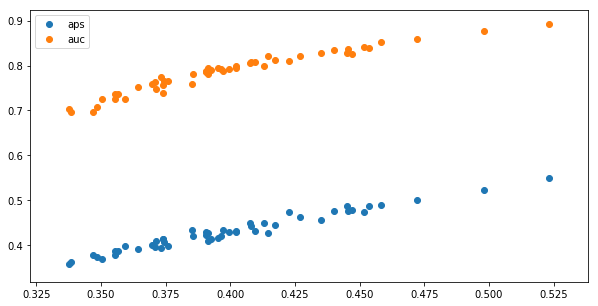

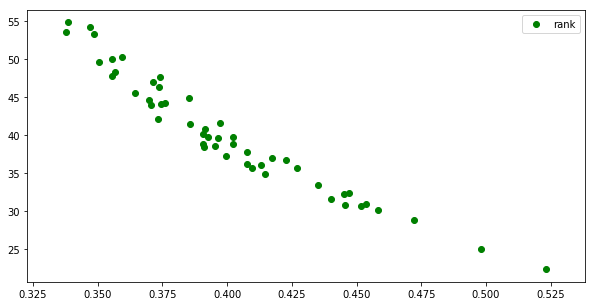

0.981428928706
0.964906152551
-0.964632373565


In [18]:
plt.figure(figsize=(10,5))
plt.scatter(tsds, aps, label="aps")
plt.scatter(tsds, auc, label="auc")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(tsds, rank, label="rank", color='g')
plt.legend()
plt.show()
print(np.corrcoef(tsds, aps)[0, 1])
print(np.corrcoef(tsds, auc)[0, 1])
print(np.corrcoef(tsds, rank)[0, 1])

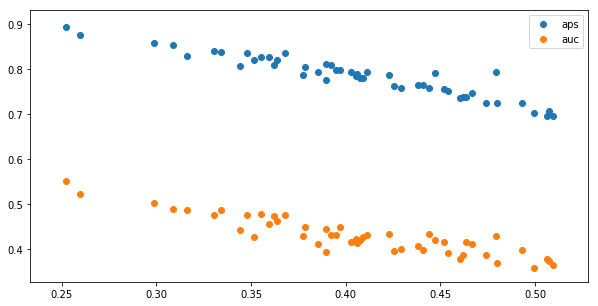

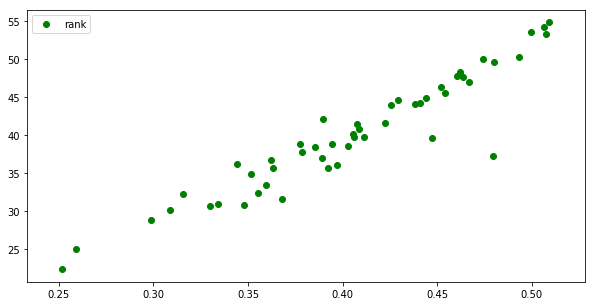

-0.908825682251
-0.951250775625
0.947037876569


In [19]:
plt.figure(figsize=(10,5))
plt.scatter(das, auc, label="aps")
plt.scatter(das, aps, label="auc")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(das, rank, label="rank", color='g')
plt.legend()
plt.show()
print(np.corrcoef(das, aps)[0, 1])
print(np.corrcoef(das, auc)[0, 1])
print(np.corrcoef(das, rank)[0, 1])

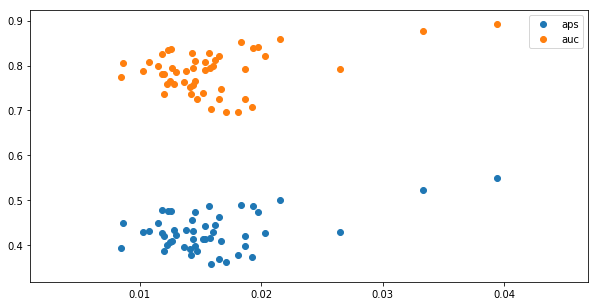

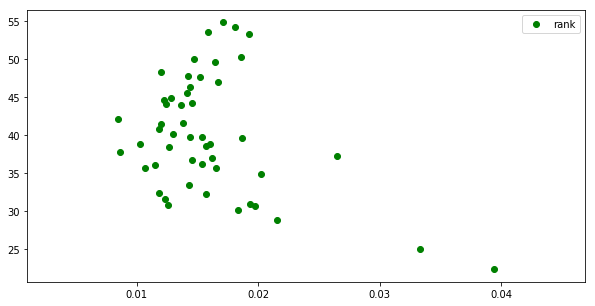

0.454460313397
0.365486977252
-0.366931234532


In [20]:
plt.figure(figsize=(10,5))
plt.scatter(euc, aps, label="aps")
plt.scatter(euc, auc, label="auc")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.scatter(euc, rank, label="rank", color='g')
plt.legend()
plt.show()
print(np.corrcoef(euc, aps)[0, 1])
print(np.corrcoef(euc, auc)[0, 1])
print(np.corrcoef(euc, rank)[0, 1])